<a href="https://colab.research.google.com/github/mohit-bags/Arrhythmia-Detection/blob/main/Arrhythmia_Detection_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trying https://github.com/spdrnl/ecg/blob/master/ECG.ipynb

In [1]:
pip install -q -U tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.5 MB/s 


In [128]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import sklearn
import itertools
import tensorflow_addons
from tensorflow_addons.optimizers import CyclicalLearningRate
import tensorflow_addons as tfa
import matplotlib as mpl
mpl.style.use('seaborn')
plt.rcParams["figure.figsize"] = (13,4)

import matplotlib.pyplot as plt 
from os import listdir 
import requests
import matplotlib.pyplot as plt
from os import listdir, mkdir, system
from os.path import isfile, isdir, join, exists
import json
import os
from tqdm import tqdm
from matplotlib import collections as matcoll

In [3]:
!unzip /content/drive/"My Drive"/"Arrythmia "/ECGDataDenoised.zip

Streaming output truncated to the last 5000 lines.
  inflating: ECGDataDenoised/MUSE_20180116_125802_57000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125812_73000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125822_43000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125825_58000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125842_09000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125845_27000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125847_39000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125906_02000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125918_29000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125919_34000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125921_43000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125925_64000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125946_45000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125948_54000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_130000_80000.csv  
  inflating: ECGDat

In [4]:
labels = pd.read_excel('/content/drive/MyDrive/Arrythmia /Diagnostics.xlsx')
labels=labels[(labels['Rhythm']=='AFIB') | (labels['Rhythm']=='AF') |(labels['Rhythm']=='SR')]
labels.reset_index(inplace=True,drop=True)
labels['Rhythm'].value_counts()

SR      1826
AFIB    1780
AF       445
Name: Rhythm, dtype: int64

In [5]:
afib_files = labels[labels['Rhythm']=="AFIB"]['FileName'].tolist()
nsr_files = labels[labels['Rhythm']=="SR"]['FileName'].tolist()
afl_files = labels[labels['Rhythm']=="AF"]['FileName'].tolist()

In [6]:
!pip3 install py-ecg-detectors


     |████████████████████████████████| 554 kB 6.3 MB/s 
  Created wheel for gatspy: filename=gatspy-0.3-py3-none-any.whl size=43818 sha256=1c6516c8b28a65e1b1cbbb3e94e418340e0812bc9a05971a727a8f3ead09bc6e
  Stored in directory: /root/.cache/pip/wheels/1f/c1/4c/8de278f816259b4f67e2356c0bda260a593375661e400bf31f
Successfully built gatspy


In [7]:
pip install neurokit2

     |████████████████████████████████| 1.1 MB 5.5 MB/s 


In [8]:
from ecgdetectors import Detectors
import neurokit2 as nk

detectors = Detectors(500) #specify sampling rate

In [9]:
def plot_rr(rrintervals,rr_diff):
  x = rrintervals/500
  y = rr_diff
  lines = []
  for i in range(len(x)):
      pair=[(x[i],0), (x[i], y[i])]
      lines.append(pair)

  linecoll = matcoll.LineCollection(lines)
  fig, ax = plt.subplots()
  ax.add_collection(linecoll)

  plt.scatter(x,y)
  plt.xticks(x)
  plt.xlabel("Time (s)")
  plt.ylim(0,1)
  plt.title("RR Peaks")
  plt.show()

def detect_r_peaks_pan_tompkins_detector(patient_list,case,detector,showplots=False):
    parent_folder = '/content/ECGDataDenoised/'
    # mxx=0
    data_with_rr = pd.DataFrame()
    for i in tqdm(patient_list):
      try:
        file_name=parent_folder+i
        df = pd.read_csv(file_name+".csv",header=None)
        df.columns=['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
        cols = df.columns
        df[cols[:-1]] = df[cols[:-1]].apply(pd.to_numeric, errors='coerce') 
        
        # Extract R-peaks locations using pan_tompkins_detector
        unfiltered_ecg=df["aVL"]
        if(detector=="pan_tompkins"):
          rpeaks = detectors.pan_tompkins_detector(unfiltered_ecg)
        elif(detector=="stationary_wavelet_transform"):
          rpeaks = detectors.swt_detector(unfiltered_ecg)

  
        rrintervals = np.array(rpeaks)
        rr_diff=np.diff(rpeaks)/1000
        # rr_diff = np.append(0, rr_diff)

        # mxx=max(len(rr_diff),mxx)

        rr_diff = np.pad(rr_diff, (0, 30-len(rr_diff)), 'constant', 
                 constant_values=(0,0)) #padded to make length 30 for all
        
        rr_diff=np.append(rr_diff,case)
        data_with_rr=data_with_rr.append(pd.DataFrame(rr_diff).transpose())

        # df_new=pd.DataFrame(data=rr_diff,columns=['RR'])
        # df_new.to_csv(file_name+"_RRi.csv")
        if(showplots): # Visualize R-peaks in ECG signal
          print("\n****",i,"****\n")
          plot = (nk.events_plot(rpeaks, df["aVL"]))
          plot_rr(rrintervals,rr_diff)
          
      except:
        print("\n ##### Error in:",i,"#####\n")
    print("\n")
    return data_with_rr

In [10]:
nsr_rr=detect_r_peaks_pan_tompkins_detector(nsr_files,"nsr","pan_tompkins",False)

100%|██████████| 1826/1826 [01:24<00:00, 21.73it/s]

In [11]:
afib_rr=detect_r_peaks_pan_tompkins_detector(afib_files,"afib","pan_tompkins",False)
afl_rr=detect_r_peaks_pan_tompkins_detector(afl_files,"afl","pan_tompkins",False)

100%|██████████| 1780/1780 [01:52<00:00, 15.82it/s]


100%|██████████| 445/445 [00:26<00:00, 16.70it/s]

In [90]:
arhy_labels = {'nsr': 0, 'afib': 1, 'afl':2}
arhy_reverse_labels = {v:k for k,v in arhy_labels.items()}

full_data_with_rr=pd.concat([afib_rr,nsr_rr,afl_rr])
full_data_with_rr.columns = [*full_data_with_rr.columns[:-1], 'label']
full_data_with_rr['label']=full_data_with_rr['label'].astype("string")
full_data_with_rr.to_csv("/content/drive/MyDrive/full_data_with_rr.csv",index=False)
arhy_labels = full_data_with_rr.iloc[:,-1].replace(arhy_reverse_labels)

In [91]:
dict = {'nsr': 0, 'afib': 1, 'afl':2}

full_data_with_rr.replace({'label': dict},inplace=True)


In [92]:
full_data_with_rr


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,label
0,0.155,0.16,0.243,0.258,0.278,0.156,0.172,0.246,0.257,0.26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
0,0.44,0.264,0.175,0.337,0.37,0.258,0.38,0.42,0.254,0.216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
0,0.18,0.504,0.388,0.36,0.394,0.382,0.34,0.447,0.411,0.532,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
0,0.18,0.349,0.352,0.575,0.272,0.317,0.364,0.481,0.332,0.368,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
0,0.152,0.428,0.346,0.524,0.293,0.378,0.303,0.242,0.386,0.352,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.594,0.604,0.731,0.589,0.723,0.668,0.59,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
0,0.283,0.579,0.269,0.223,0.158,0.435,0.206,0.181,0.326,0.304,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
0,0.223,0.182,0.198,0.214,0.204,0.198,0.199,0.193,0.196,0.197,...,0.176,0.219,0.197,0.0,0.0,0.0,0.0,0.0,0.0,2
0,0.183,0.19,0.159,0.191,0.201,0.206,0.218,0.21,0.186,0.192,...,0.202,0.234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


Text(0.5, 1.0, 'Distribution of the MIT BIH Database labels')

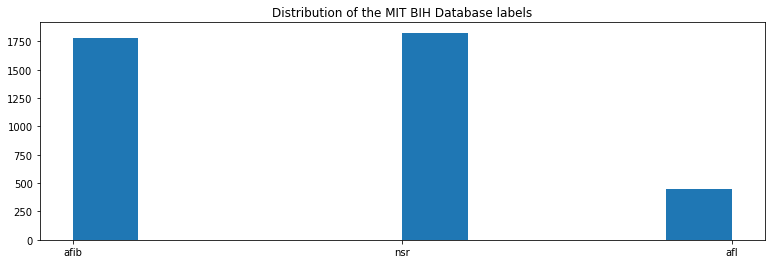

In [93]:
plt.hist(arhy_labels)
plt.title("Distribution of the MIT BIH Database labels")

In [94]:
arhy_labels.count()

4051

max number of RR Intervals is 30, so we will do padding

In [95]:
# Now stored as  parent_folder+patient_id+"_RRi.csv"

In [96]:
# Copied from https://github.com/avanwyk/tensorflow-projects/blob/master/lr-finder/lr_finder.py
# Apache License 2.0

from tensorflow.keras.callbacks import Callback

class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [97]:
def pretty_plot(history, field, fn):
  def plot(data, val_data, best_index, best_value, title):
    plt.plot(range(1, len(data)+1), data, label='train')
    plt.plot(range(1, len(data)+1), val_data, label='validation')
    if not best_index is None:
      plt.axvline(x=best_index+1, linestyle=':', c="#777777")
    if not best_value is None:
      plt.axhline(y=best_value, linestyle=':', c="#777777")
    plt.xlabel('Epoch')
    plt.ylabel(field)
    plt.xticks(range(0, len(data), 20))
    plt.title(title)
    plt.legend()
    plt.show()

  data = history.history[field]
  val_data = history.history['val_' + field]
  tail = int(0.15 * len(data))

  best_index = fn(val_data)
  best_value = val_data[best_index]

  plot(data, val_data, best_index, best_value, "{} over epochs (best {:06.4f})".format(field, best_value))
  plot(data[-tail:], val_data[-tail:], None, best_value, "{} over last {} epochs".format(field, tail))

In [98]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [99]:
def get_base_model(categories=2):
  return keras.Sequential([
    keras.layers.Dense(15, activation='relu', input_shape=[30], kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.Dense(5, activation='relu'),
    (keras.layers.Dense(1, activation='sigmoid') if categories == 2 else keras.layers.Dense(5, activation='softmax'))                   
  ])

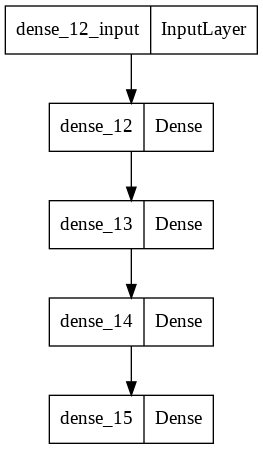

In [100]:
tf.keras.utils.plot_model(
    get_base_model(),
    to_file="model.png")

In [101]:
# all_subjects= afib_files+ nsr_files + afl_files

# subject_label = {}
# for i in afib_files:
#     subject_label[i] = 1 #'afib'
# for i in nsr_files:
#     subject_label[i] = 0 #'nsr'
# for i in afl_files:
#     subject_label[i] = 2 # afl'

In [102]:
# all_subjects

In [103]:
# train_file_names, test_val_files = train_test_split(all_subjects, test_size=0.2, random_state=2)
# test_file_names, val_file_names = train_test_split(test_val_files,test_size=0.5,random_state=3)

In [104]:
# print(len(train_file_names),len(test_file_names),len(val_file_names))

In [105]:
# cnt_train={}
# for i in train_file_names:
#   label=subject_label[i]
#   if label in cnt_train:
#       cnt_train[label]+=1
#   else:
#       cnt_train[label]=1
# print("Train:",cnt_train)

# cnt_test={}
# for i in test_file_names:
#   label=subject_label[i]
#   if label in cnt_test:
#       cnt_test[label]+=1
#   else:
#       cnt_test[label]=1
# print("test:",cnt_test)

# cnt_val={}
# for i in val_file_names:
#   label=subject_label[i]
#   if label in cnt_val:
#       cnt_val[label]+=1
#   else:
#       cnt_val[label]=1
# print("val:",cnt_val)

In [106]:
# def chunker(seq, size):
#     return (seq[pos:pos + size] for pos in range(0, len(seq), size))

# def train_generator(list_files, batch_size=8):
#     while True:
#         for batch_files in chunker(list_files, size=batch_size):
#             batch_data = [load_audio_file(fpath) for fpath in batch_files]
#             batch_data = np.array(batch_data)[:,:,np.newaxis]
#             batch_labels = [file_to_int[fpath] for fpath in batch_files]
#             batch_labels = np.array(batch_labels)
            
#             yield batch_data, batch_labels

In [112]:
full_data_with_rr.iloc[:,-1]

0    1
0    1
0    1
0    1
0    1
    ..
0    2
0    2
0    2
0    2
0    2
Name: label, Length: 4051, dtype: int64

In [119]:
full_data_with_rr
for i in range(0,30):
  full_data_with_rr[i]=full_data_with_rr[i].astype("float")

In [121]:
full_data_with_rr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4051 entries, 0 to 0
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       4051 non-null   float64
 1   1       4051 non-null   float64
 2   2       4051 non-null   float64
 3   3       4051 non-null   float64
 4   4       4051 non-null   float64
 5   5       4051 non-null   float64
 6   6       4051 non-null   float64
 7   7       4051 non-null   float64
 8   8       4051 non-null   float64
 9   9       4051 non-null   float64
 10  10      4051 non-null   float64
 11  11      4051 non-null   float64
 12  12      4051 non-null   float64
 13  13      4051 non-null   float64
 14  14      4051 non-null   float64
 15  15      4051 non-null   float64
 16  16      4051 non-null   float64
 17  17      4051 non-null   float64
 18  18      4051 non-null   float64
 19  19      4051 non-null   float64
 20  20      4051 non-null   float64
 21  21      4051 non-null   float64
 22  22 

In [122]:
X_arhy_train, X_arhy_val, y_arhy_train, y_arhy_val = train_test_split(full_data_with_rr.iloc[:,:-1].values, full_data_with_rr.iloc[:,-1].values, test_size=0.2, random_state=42)
X_arhy_val, X_arhy_test, y_arhy_val, y_arhy_test  = train_test_split(X_arhy_val, y_arhy_val, test_size=0.5, random_state=42)

print("All features size {}".format(full_data_with_rr.iloc[:,:-1].shape))
print("Train features size {}".format(X_arhy_train.shape))
print("Validation features size {}".format(X_arhy_val.shape))
print("Test features size {}".format(X_arhy_test.shape))

All features size (4051, 30)
Train features size (3240, 30)
Validation features size (405, 30)
Test features size (406, 30)


In [123]:
X_arhy_train

array([[0.649, 0.456, 0.606, ..., 0.   , 0.   , 0.   ],
       [0.476, 0.669, 0.611, ..., 0.   , 0.   , 0.   ],
       [0.154, 0.459, 0.322, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.26 , 0.296, 0.225, ..., 0.   , 0.   , 0.   ],
       [0.187, 0.484, 0.44 , ..., 0.   , 0.   , 0.   ],
       [0.374, 0.436, 0.442, ..., 0.   , 0.   , 0.   ]])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


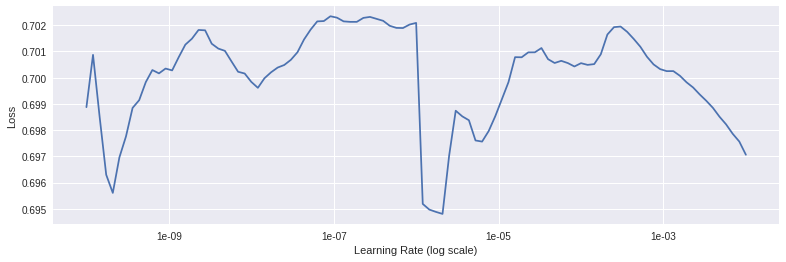

In [137]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = get_base_model() 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-10, end_lr= 1e-2, max_steps=100, smoothing=0.6)
_ = model.fit(X_arhy_train, y_arhy_train, batch_size=64, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [138]:
# Set cyclical learning rate
N = X_arhy_train.shape[0]
batch_size = 32
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-4, 1e-2, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

base_model = get_base_model() 
base_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = base_model.fit(X_arhy_train, y_arhy_train, validation_data=(X_arhy_val, y_arhy_val), 
                         shuffle=True, batch_size=batch_size, epochs=150, callbacks=[save_best_weights])

Epoch 1/150
102/102 [==============================] - 3s 14ms/step - loss: 0.6451 - accuracy: 0.5546 - val_loss: 0.4356 - val_accuracy: 0.6568
Epoch 2/150
102/102 [==============================] - 1s 10ms/step - loss: -1.0720 - accuracy: 0.5886 - val_loss: -7.7341 - val_accuracy: 0.4494
Epoch 3/150
102/102 [==============================] - 1s 10ms/step - loss: -59.0346 - accuracy: 0.5451 - val_loss: -129.5190 - val_accuracy: 0.6346
Epoch 4/150
102/102 [==============================] - 1s 6ms/step - loss: -198.9297 - accuracy: 0.5630 - val_loss: -226.1806 - val_accuracy: 0.6074
Epoch 5/150
102/102 [==============================] - 1s 6ms/step - loss: -270.1595 - accuracy: 0.5630 - val_loss: -333.7591 - val_accuracy: 0.5654
Epoch 6/150
102/102 [==============================] - 1s 6ms/step - loss: -586.4713 - accuracy: 0.5602 - val_loss: -1019.3914 - val_accuracy: 0.6247
Epoch 7/150
102/102 [==============================] - 1s 7ms/step - loss: -1981.9558 - accuracy: 0.5364 - val_lo

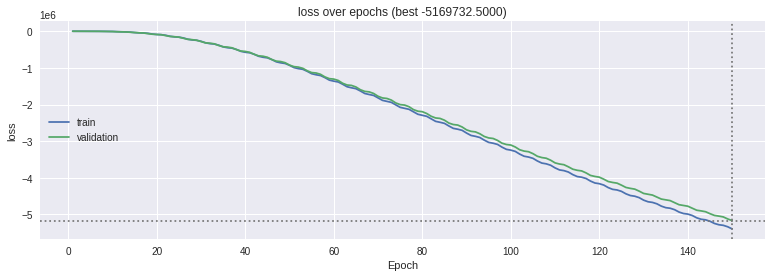

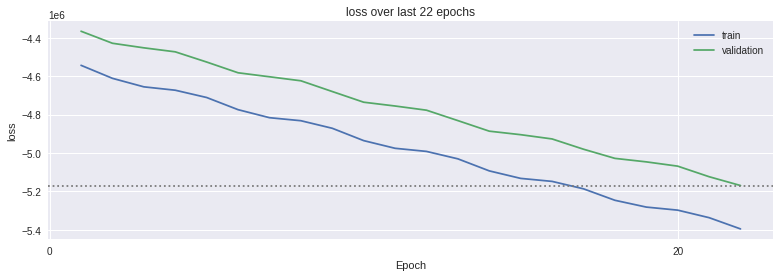

In [139]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

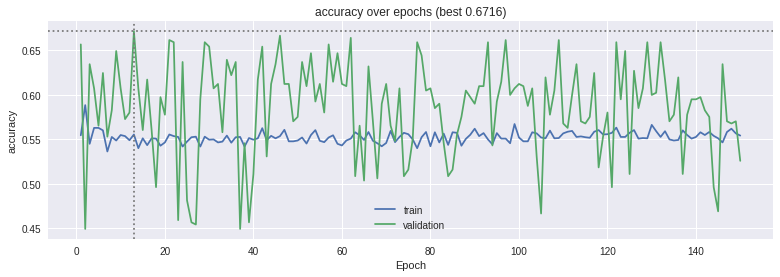

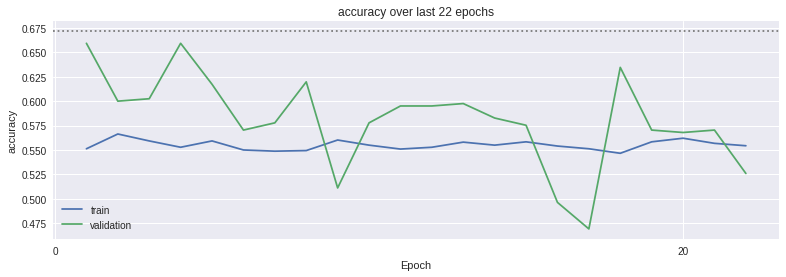

In [140]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [141]:
base_model.load_weights('weights.hdf5')
base_model.evaluate(X_arhy_test, y_arhy_test)

13/13 [==============================] - 0s 8ms/step - loss: -4197125.5000 - accuracy: 0.5172


[-4197125.5, 0.517241358757019]

Confusion matrix, without normalization
[[ 57 122   0]
 [ 41 153   0]
 [  3  30   0]]


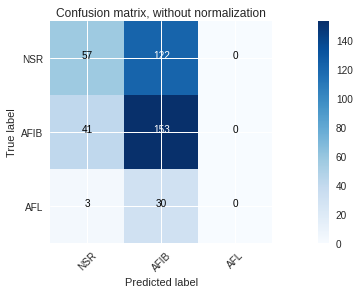

In [143]:
y_pred = (base_model.predict(X_arhy_test) > 0.5).astype("int32")

# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_arhy_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['NSR', 'AFIB','AFL'],
                      title='Confusion matrix, without normalization')

### ResNet Model

In [164]:
def get_resnet_model(categories=3):
  def residual_block(X, kernels, stride):
    out = keras.layers.Conv1D(kernels, stride, padding='same')(X)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.add([X, out])
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(1, 3)(out)
    return out

  kernels = 32
  stride = 1

  inputs = keras.layers.Input([30,1])
  X = keras.layers.Conv1D(kernels, stride)(inputs)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = keras.layers.Flatten()(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  output = (keras.layers.Dense(1, activation='sigmoid')(X) if categories == 3 else keras.layers.Dense(5, activation='softmax')(X))

  model = keras.Model(inputs=inputs, outputs=output)
  return model

In [165]:
X_arhyl_train = np.expand_dims(X_arhy_train, -1)
y_arhyl_train = np.expand_dims(y_arhy_train, -1)

X_arhyl_val = np.expand_dims(X_arhy_val, -1)
y_arhyl_val = np.expand_dims(y_arhy_val, -1)

X_arhyl_test = np.expand_dims(X_arhy_test, -1)
y_arhyl_test = np.expand_dims(y_arhy_test, -1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


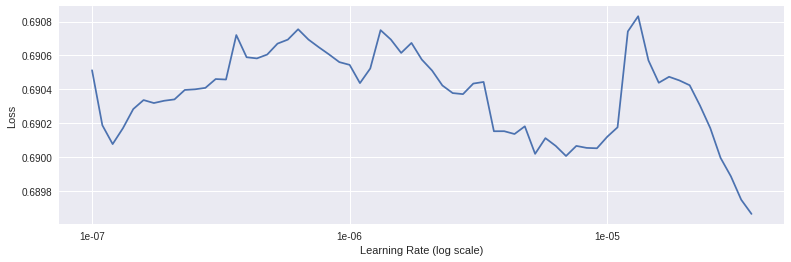

In [166]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = get_resnet_model() 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-03, max_steps=100, smoothing=0.6)
_ = model.fit(X_arhyl_train, y_arhyl_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [167]:
# Set cyclical learning rate
N = X_arhyl_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-6, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

resnet_model = get_resnet_model() 
resnet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = resnet_model.fit(X_arhyl_train, y_arhyl_train, validation_data=(X_arhyl_val, y_arhyl_val), 
                           shuffle=True, batch_size=batch_size, epochs=75, callbacks=[save_best_weights])

Epoch 1/75
26/26 [==============================] - 3s 39ms/step - loss: 0.6783 - accuracy: 0.4321 - val_loss: 0.6526 - val_accuracy: 0.4593
Epoch 2/75
26/26 [==============================] - 0s 17ms/step - loss: 0.6520 - accuracy: 0.4321 - val_loss: 0.6294 - val_accuracy: 0.4593
Epoch 3/75
26/26 [==============================] - 0s 17ms/step - loss: 0.6328 - accuracy: 0.4321 - val_loss: 0.6011 - val_accuracy: 0.4593
Epoch 4/75
26/26 [==============================] - 0s 18ms/step - loss: 0.6145 - accuracy: 0.4321 - val_loss: 0.5915 - val_accuracy: 0.4593
Epoch 5/75
26/26 [==============================] - 0s 17ms/step - loss: 0.6092 - accuracy: 0.4318 - val_loss: 0.5906 - val_accuracy: 0.4642
Epoch 6/75
26/26 [==============================] - 0s 18ms/step - loss: 0.6068 - accuracy: 0.4756 - val_loss: 0.5802 - val_accuracy: 0.5383
Epoch 7/75
26/26 [==============================] - 0s 13ms/step - loss: 0.6073 - accuracy: 0.4991 - val_loss: 0.5911 - val_accuracy: 0.5185
Epoch 8/75
26

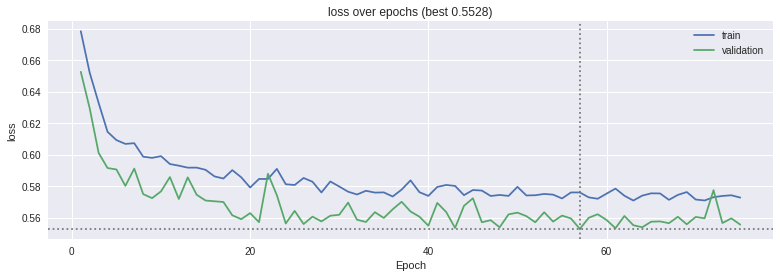

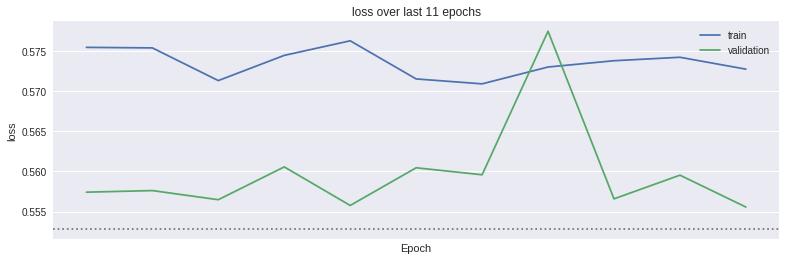

In [168]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

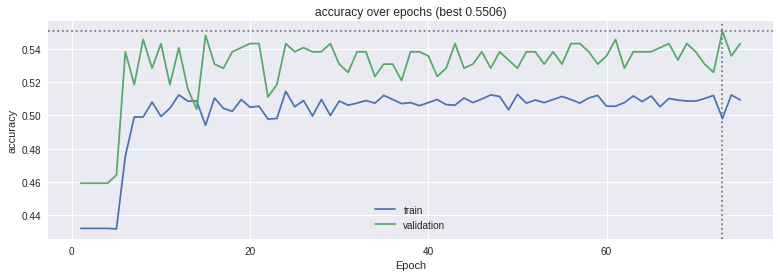

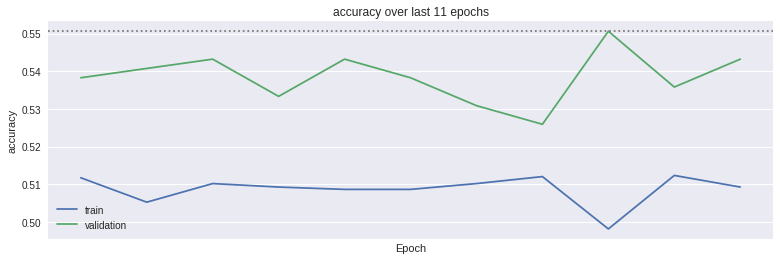

In [169]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [170]:
resnet_model.load_weights('weights.hdf5')
resnet_model.evaluate(X_arhyl_test, y_arhyl_test)

13/13 [==============================] - 0s 17ms/step - loss: 0.6401 - accuracy: 0.5222


[0.6400601267814636, 0.5221675038337708]

Confusion matrix, without normalization
[[ 43 136   0]
 [ 25 169   0]
 [  1  32   0]]


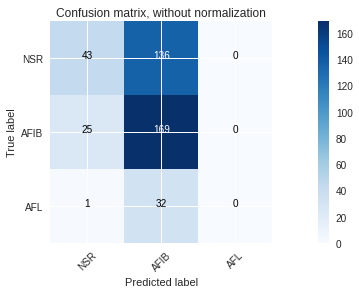

In [172]:
y_pred = (resnet_model.predict(X_arhyl_test) > 0.5).astype("int32")
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_arhy_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['NSR', 'AFIB','AFL'],
                      title='Confusion matrix, without normalization')

## ResNet MIT-BIH replication

In [174]:
X_arhy_train, X_arhy_val, y_arhy_train, y_arhy_val = train_test_split(arhy_train.iloc[:,:-1].values, arhy_train.iloc[:,-1].values, test_size=0.1, random_state=42)
X_arhy_test = arhy_test.iloc[:,:-1].values
y_arhy_test = arhy_test.iloc[:,-1].values

# The 1D convolutions expect an extra dimension in the input data 
X_arhyl_train = np.expand_dims(X_arhy_train, -1)
y_arhyl_train = np.expand_dims(y_arhy_train, -1)
X_arhyl_val = np.expand_dims(X_arhy_val, -1)
y_arhyl_val = np.expand_dims(y_arhy_val, -1)
X_arhyl_test = np.expand_dims(X_arhy_test, -1)
y_arhyl_test = np.expand_dims(y_arhy_test, -1)

NameError: ignored

In [ ]:
list_labels=[0,1,2]
def get_model():
    nclass = len(list_labels)
    inp = Input(shape=(input_length, 1))
    img_1 = Convolution1D(16, kernel_size=9, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=9, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=4)(img_1)
    img_1 = Dropout(rate=0.4)(img_1)
    img_1 = Convolution1D(16, kernel_size=9, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=9, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=4)(img_1)
    img_1 = Dropout(rate=0.4)(img_1)
    
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu)(img_1)
    dense_1 = Dense(1028, activation=activations.relu)(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    # opt = optimizers.Adam(0.0025)
    import tensorflow as tf
    opt=tf.optimizers.Adam(0.0025)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model
